# Applying Machine Learning to Stock Price Prediction
#### Donovan Wood, James Ohr, Andre Xiao  

## Abstract

* What problem did we address?
* What approach(es) did we use to address it?
* What are the big-picture results?

## Introduction

* Prompt: "Your introduction should describe the big-picture problem that you aimed to address in your project. What’s the problem to be solved, and why is it important? Who has tried solving this problem already, and what did they do? I would expect most introductions to reference no fewer than 2 scholarly studies that attempted similar tasks, although 5 is probably a better target."

In this blog post, we train machine learning models on historical stock market data to predict future stock price movements. This is a highly popular problem to address because of the potential for significant monetary gain. This is an important problem societally because stock markets are mechanisms of price discovery: they answer the question "What is a company worth?" Finding the right answer to that question allows society to correctly allocate more or less capital (money) to that company. On an individual level, this is an important problem to us as the authors because it's the problem for all quant trading: making a profitable model. 

An enormous body of literature within and without computer science exists for stock market prediction. Among the papers most relevant to our work are Bhandari et al. (2022) and Zhang (2022).

[Gunduz (2021)](https://jfin-swufe.springeropen.com/articles/10.1186/s40854-021-00243-3) applies LSTM and ensemble learning (Light-GBM) models to predict the hourly directions of eight banking stocks in Borsa Istanbul. He achieved up to maximum success rate of 0.685 using individual features of bank stocks and LSTM.

[Bhandari et al. (2022)](https://www.sciencedirect.com/science/article/pii/S2666827022000378) apply single-layer and multi-layer LSTM models to the problem of predicting the S&P 500, the index of the largest 500 publicly traded companies in America. Their single-layer LTSM model with 150 neurons is their best performing specification. Their set of predicted values have an average correlation coefficient of 0.9976 with actual S&P index values.

[Zhang (2022)](https://www.atlantis-press.com/proceedings/icfied-22/125971905) finds the LSTM network model does not perform better than other models when applied to a short forecasting horizon (1 to 10 days). Zhang's "other models" are linear regression, eXtreme gradient boosting (XGBoost), last value, and moving average.

We take some of the "best practices" we observe in the above papers, specifically benchmarking with last value and calculating accuracy with R, RMSE, and MAPE. Unlike the mentioned papers, we will be focusing on single stocks and attempting to build a model that outperforms the last value benchmark.

## Values


* Who are the potential users of your project? Who, other than your users, might still be affected by your project?
* Who benefits from technology that solves the problem you address?
* Who could be harmed from technology that solves the problem you well address?
* What is your personal reason for working on this problem?
* Based on your reflection, would the world be a more equitable, just, joyful, peaceful, or sustainable place based on the technology that you implemented?


In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from yahoofinancials import YahooFinancials as YF

In [3]:
# Define the ticker and the time period
ticker = 'TSLA'
start_date = '2019-01-01'
end_date = '2020-01-01'

# Fetch TSLA data
tsla = yf.download(ticker, start=start_date, end=end_date)

print(tsla.head())

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2019-01-02  20.406668  21.008667  19.920000  20.674667  20.674667  174879000
2019-01-03  20.466667  20.626667  19.825333  20.024000  20.024000  104478000
2019-01-04  20.400000  21.200001  20.181999  21.179333  21.179333  110911500
2019-01-07  21.448000  22.449333  21.183332  22.330667  22.330667  113268000
2019-01-08  22.797333  22.934000  21.801332  22.356667  22.356667  105127500


In [4]:
# Moving Average 
short_window = 40
long_window = 100

tsla['Short_MAvg'] = tsla['Close'].rolling(window=short_window, min_periods=1).mean()
tsla['Long_MAvg'] = tsla['Close'].rolling(window=long_window, min_periods=1).mean()

In [5]:
# Basic trading signal based on crossover 

# Create a 'Signal' column
tsla['Signal'] = 0
tsla['Signal'] = np.where(tsla['Short_MAvg'] > tsla['Long_MAvg'], 1, 0)

In [6]:
# Generate trading orders
tsla['Position'] = tsla['Signal'].diff()

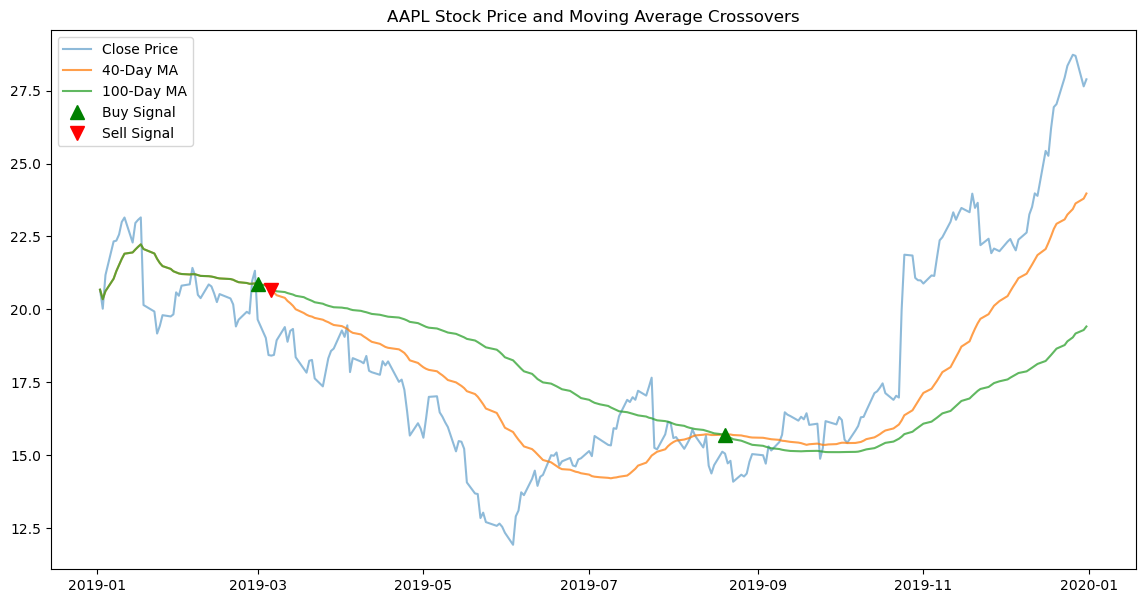

In [7]:
# Basic Back Test

# Plot the closing prices and moving averages
plt.figure(figsize=(14,7))
plt.plot(tsla['Close'], label='Close Price', alpha=0.5)
plt.plot(tsla['Short_MAvg'], label=f'{short_window}-Day MA', alpha=0.75)
plt.plot(tsla['Long_MAvg'], label=f'{long_window}-Day MA', alpha=0.75)

# Plot buy signals
plt.plot(tsla[tsla['Position'] == 1].index, tsla['Short_MAvg'][tsla['Position'] == 1], '^', markersize=10, color='g', lw=0, label='Buy Signal')

# Plot sell signals
plt.plot(tsla[tsla['Position'] == -1].index, tsla['Short_MAvg'][tsla['Position'] == -1], 'v', markersize=10, color='r', lw=0, label='Sell Signal')

plt.title('AAPL Stock Price and Moving Average Crossovers')
plt.legend()
plt.show()

In [8]:
tsla['Std_Dev'] = tsla['Close'].rolling(window=short_window, min_periods=1).std()

# Calculate the z-score
tsla['Z_Score'] = (tsla['Close'] - tsla['Short_MAvg']) / tsla['Std_Dev']

In [9]:
# Define thresholds for buying and selling
threshold_buy = -1.5  # Buy signal threshold
threshold_sell = 1.5  # Sell signal threshold

# Generate signals
tsla['Signal'] = 0
tsla['Signal'][tsla['Z_Score'] > threshold_sell] = -1  # Sell signal
tsla['Signal'][tsla['Z_Score'] < threshold_buy] = 1  # Buy signal

# Generate trading positions
tsla['Position'] = tsla['Signal'].replace(0, np.nan).ffill().fillna(0)

C:\Users\james\AppData\Local\Temp\ipykernel_70572\3954209935.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla['Signal'][tsla['Z_Score'] > threshold_sell] = -1  # Sell signal
C:\Users\james\AppData\Local\Temp\ipykernel_70572\3954209935.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla['Signal'][tsla['Z_Score'] < threshold_buy] = 1  # Buy signal


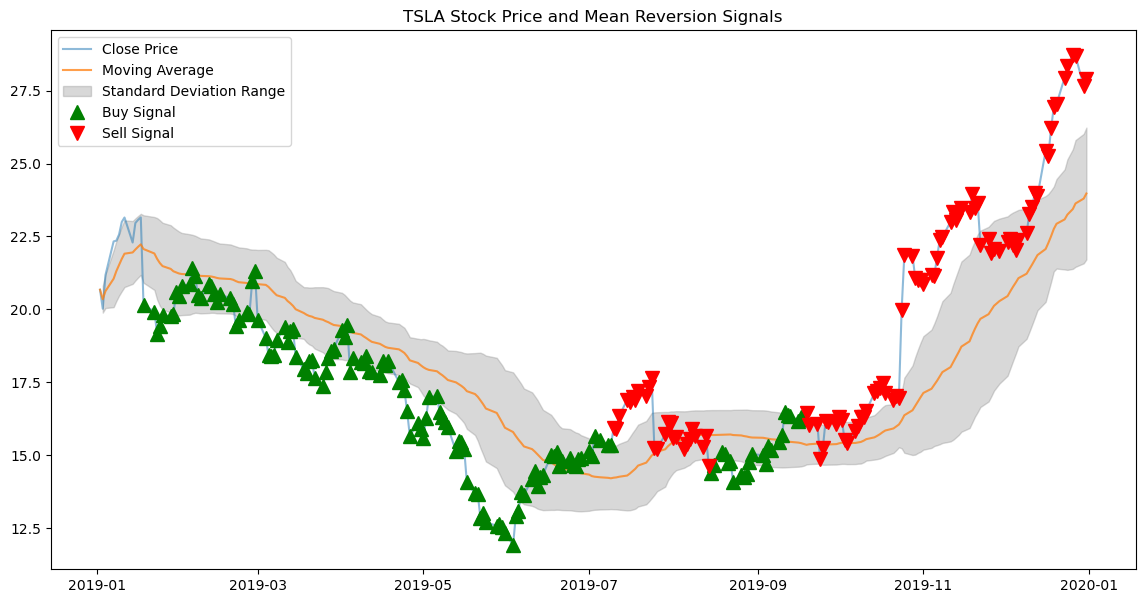

In [10]:
# Plot the results
plt.figure(figsize=(14,7))
plt.plot(tsla['Close'], label='Close Price', alpha=0.5)
plt.plot(tsla['Short_MAvg'], label='Moving Average', alpha=0.75)
plt.fill_between(tsla.index, tsla['Short_MAvg'] - tsla['Std_Dev'], tsla['Short_MAvg'] + tsla['Std_Dev'], color='gray', alpha=0.3, label='Standard Deviation Range')

# Highlight the buy and sell signals
plt.plot(tsla[tsla['Position'] == 1].index, tsla['Close'][tsla['Position'] == 1], '^', markersize=10, color='g', lw=0, label='Buy Signal')
plt.plot(tsla[tsla['Position'] == -1].index, tsla['Close'][tsla['Position'] == -1], 'v', markersize=10, color='r', lw=0, label='Sell Signal')

plt.title(f'{ticker} Stock Price and Mean Reversion Signals')
plt.legend()
plt.show()

## Model Analysis

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Accuracy: 0.4946695095948827


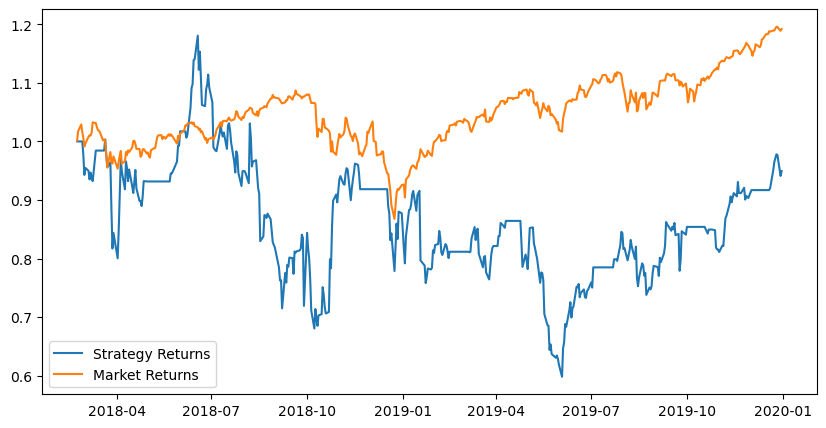

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

ticker = 'TSLA'
start_date = '2010-01-01'
end_date = '2020-01-01'

model = LogisticRegression()

data = yf.download(ticker, start=start_date, end=end_date)

# Calculate moving averages and std
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['Std_Dev'] = data['Close'].rolling(window=20).std()

# Calculate the z-score
data['Z_Score'] = (data['Close'] - data['SMA_20']) / data['Std_Dev']

# Calculate RSI
delta = data['Close'].diff()
up = delta.clip(lower=0)
down = -1 * delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up / ema_down

data['RSI'] = 100 - (100 / (1 + rs))

# Calculate the daily returns
data['Returns'] = data['Close'].pct_change()

# Drop any NaNs
data.dropna(inplace=True)

# If stock price goes up or down
data['Target'] = (data['Returns'].shift(-1) > 0).astype(int)

# Wanted features for X and y
features = ['SMA_20', 'SMA_50', 'Std_Dev', 'Z_Score', 'RSI', 'Returns']
X = data[features]
y = data['Target']

# Split data into first 80% and last 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate cumulative strategy returns on test data
X_test['Predicted_Signal'] = y_pred
X_test['Strategy_Returns'] = X_test['Returns'] * X_test['Predicted_Signal'].shift(1)
cumulative_strategy_returns = (X_test['Strategy_Returns'] + 1).cumprod()

# Calculate cumulative returns for the market
spy = yf.download('SPY', start=X_test.index[0].date().strftime('%Y-%m-%d'), end=end_date)
spy['Returns'] = spy['Close'].pct_change()
cumulative_market_returns = (spy['Returns'] + 1).cumprod()

plt.figure(figsize=(10,5))
plt.plot(cumulative_strategy_returns, label='Strategy Returns')
plt.plot(cumulative_market_returns, label='Market Returns')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def train(model, ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    
    # Calculate moving averages and std
    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['Std_Dev'] = data['Close'].rolling(window=20).std()

    # Calculate the z-score
    data['Z_Score'] = (data['Close'] - data['SMA_20']) / data['Std_Dev']

    # Calculate RSI
    delta = data['Close'].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ema_up = up.ewm(com=13, adjust=False).mean()
    ema_down = down.ewm(com=13, adjust=False).mean()
    rs = ema_up / ema_down

    data['RSI'] = 100 - (100 / (1 + rs))

    # Calculate the daily returns
    data['Returns'] = data['Close'].pct_change()

    # Drop any NaNs
    data.dropna(inplace=True)

    # If stock price goes up or down
    data['Target'] = (data['Returns'].shift(-1) > 0).astype(int)

    # Wanted features for X and y
    features = ['SMA_20', 'SMA_50', 'Std_Dev', 'Z_Score', 'RSI', 'Returns']
    X = data[features]
    y = data['Target']

    # Split data into first 80% and last 20%
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Calculate cumulative strategy returns on test data
    X_test['Predicted_Signal'] = y_pred
    X_test['Strategy_Returns'] = X_test['Returns'] * X_test['Predicted_Signal'].shift(1)
    cumulative_strategy_returns = (X_test['Strategy_Returns'] + 1).cumprod()

    # Calculate cumulative returns for the market
    spy = yf.download('SPY', start=X_test.index[0].date().strftime('%Y-%m-%d'), end=end_date)
    spy['Returns'] = spy['Close'].pct_change()
    cumulative_market_returns = (spy['Returns'] + 1).cumprod()
    
    plt.figure(figsize=(10,5))
    plt.plot(cumulative_strategy_returns, label='Strategy Returns')
    plt.plot(cumulative_market_returns, label='Market Returns')
    plt.legend()
    plt.show()

In [14]:
#| code-fold: true
%load_ext autoreload
%autoreload 2
from strategy import MeanReversion

In [15]:
ticker = 'TSLA'
market = 'SPY'
start = '2014-01-01'
end = '2024-01-01'
MR = MeanReversion(ticker, start, end, market)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Accuracy: 0.5263157894736842


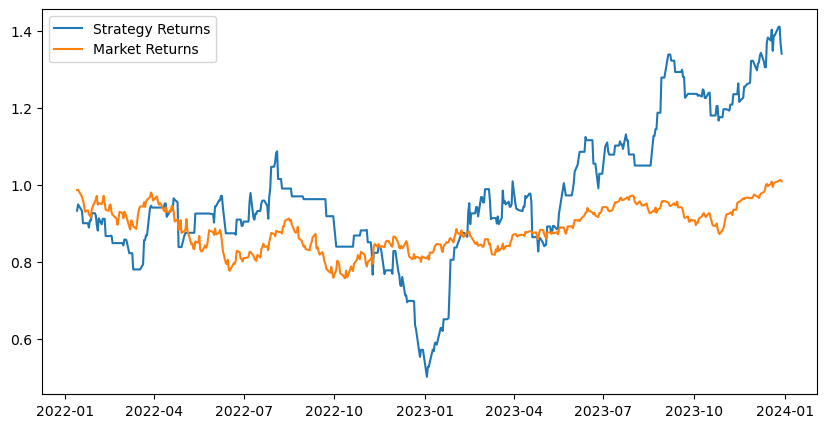

In [16]:
RF = RandomForestClassifier(n_estimators=100, random_state=42)
X_test = MR.evaluate(model=RF)

Accuracy: 0.5041322314049587


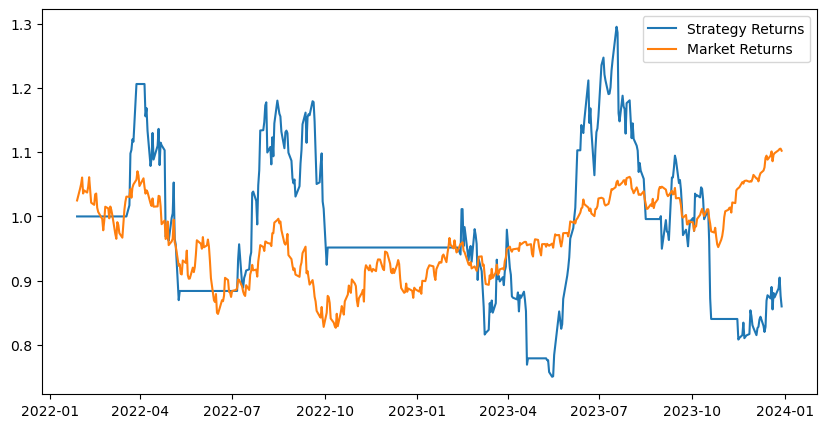

In [17]:
LR = LogisticRegression()
X_test = MR.evaluate(model=LR)

Accuracy: 0.5337552742616034


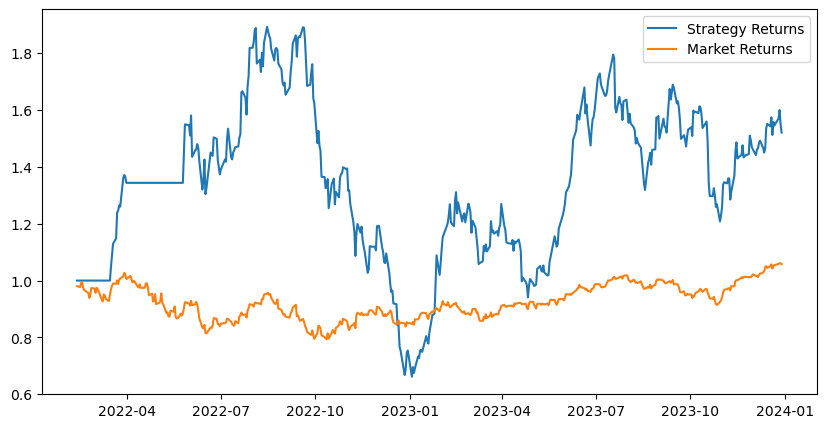

In [18]:
SVM = SVC()
X_test = MR.evaluate(model = SVM)

Note: Different models work better for different stocks.

Below, we calculate the "risk-free rate," used as a reference for all returns in financial markets. It is considered the return on an investment that is considered to have zero risk (short-term US treasuries). We use the risk-free rate to calculate the Sharpe ratio, which is a widely-used measure of an investment or a strategy's "risk-adjusted" performance. 

In [19]:
def deannualize(annual_rate, periods=365):
    return (1 + annual_rate) ** (1/periods) - 1

def get_risk_free_rate(start_date, end_date):
    # download 3-month us treasury bills rates
    annualized = yf.download('^IRX', start_date, end_date)['Close']
    annualized = annualized / 100
    
    # de-annualize
    daily = annualized.apply(deannualize)

    # create dataframe
    return pd.DataFrame({"annualized": annualized, "daily": daily})

## Pytrends

In [20]:
from pytrends.request import TrendReq
from pytrends import dailydata

In [21]:
pytrends = TrendReq(hl = 'en-US', tz=360)

In [22]:
pytrends.build_payload(kw_list=['Microsoft', 'Tesla', 'Apple'], timeframe='2010-01-01 2020-01-01')

## Basket Analysis

In [71]:
tickers = ['XOM', 'CVX', 'COP', 'NEE', 'SO', 'EOG', 'DUK', 'MPC', 'SLB', 'PSX']

def prepare_data(tickers, start_date, end_date):
    '''
    Combines data of all tickers into a single dataframe for X_train. X_test is a list of dataframes for each ticker.
    '''
    X_train_list = []
    y_train_list = []
    X_test_list = []
    y_test_list = []
    for t in tickers:
        data = yf.download(t, start=start_date, end=end_date)
        # Calculate moving averages and std
        data['SMA_20'] = data['Close'].rolling(window=20).mean()
        data['SMA_50'] = data['Close'].rolling(window=50).mean()
        data['Std_Dev'] = data['Close'].rolling(window=20).std()

        # Calculate the z-score
        data['Z_Score'] = (data['Close'] - data['SMA_20']) / data['Std_Dev']

        # Calculate RSI
        delta = data['Close'].diff()
        up = delta.clip(lower=0)
        down = -1 * delta.clip(upper=0)
        ema_up = up.ewm(com=13, adjust=False).mean()
        ema_down = down.ewm(com=13, adjust=False).mean()
        rs = ema_up / ema_down

        data['RSI'] = 100 - (100 / (1 + rs))

        # Calculate the daily returns
        data['Returns'] = data['Close'].pct_change()

        # Drop any NaNs
        data.dropna(inplace=True)

        # If stock price goes up or down
        data['Target'] = (data['Returns'].shift(-1) > 0).astype(int)
        data['Ticker'] = t
        features = ['Ticker', 'SMA_20', 'SMA_50', 'Std_Dev', 'Z_Score', 'RSI', 'Returns']
        X = data[features]
        y = data['Target']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
        X_train_list.append(X_train)
        y_train_list.append(y_train)
        X_test_list.append(X_test)
        y_test_list.append(y_test)

    return pd.concat(X_train_list, ignore_index=True), pd.concat(y_train_list, ignore_index=True), X_test_list, y_test_list

In [131]:
def evaluate(model, X_test_, y_test_, features, market_data):
    '''
    Compares returns to the market for a single ticker.
    '''
    X_test = X_test_.copy()
    y_test = y_test_.copy()
    
    y_pred = model.predict(X_test[features])
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{X_test.Ticker.iloc[0]} Accuracy:", accuracy)

    # Calculate cumulative strategy returns on test data
    X_test['Predicted_Signal'] = y_pred
    X_test['Strategy_Returns'] = X_test['Returns'] * X_test['Predicted_Signal'].shift(1)
    cumulative_strategy_returns = (X_test['Strategy_Returns'].fillna(0) + 1).cumprod()
    returns = X_test.loc[X_test.index, 'Returns']
    returns.iloc[0] = 0
    cumulative_stock_returns = (returns + 1).cumprod()

    # Calculate cumulative returns for the market
    market_data['Returns'] = market_data['Close'].pct_change()
    #cumulative_market_returns = (market_data['Returns'].fillna(0) + 1).cumprod()

    plt.figure(figsize=(10,5))
    plt.plot(cumulative_strategy_returns, label='Strategy Returns', alpha=0.5)
    #plt.plot(cumulative_market_returns, label='Market Returns')
    plt.plot(cumulative_stock_returns, label='Stock Returns', alpha=0.5)
    plt.title(f'{X_test.Ticker.iloc[0]} Returns')
    plt.legend()
    plt.show()

    return X_test

In [73]:
start = '2014-01-01'
end = '2024-01-01'
X_train, y_train, X_test, y_test = prepare_data(tickers, start, end)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


XOM Accuracy: 0.52834008097166


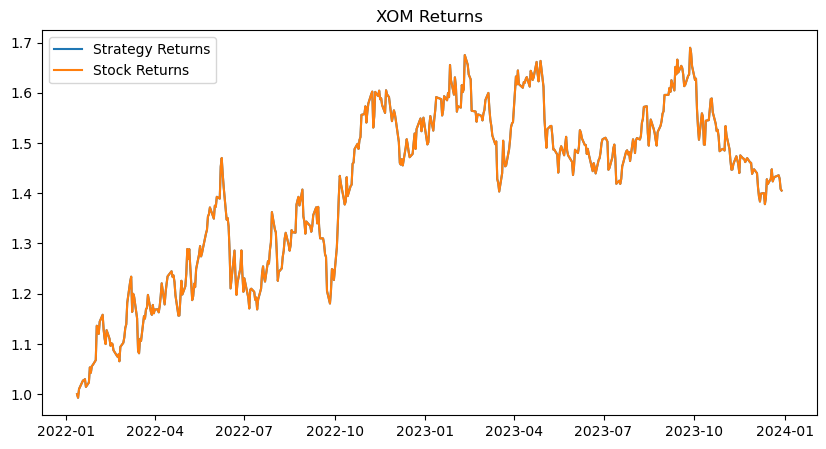

CVX Accuracy: 0.48380566801619435


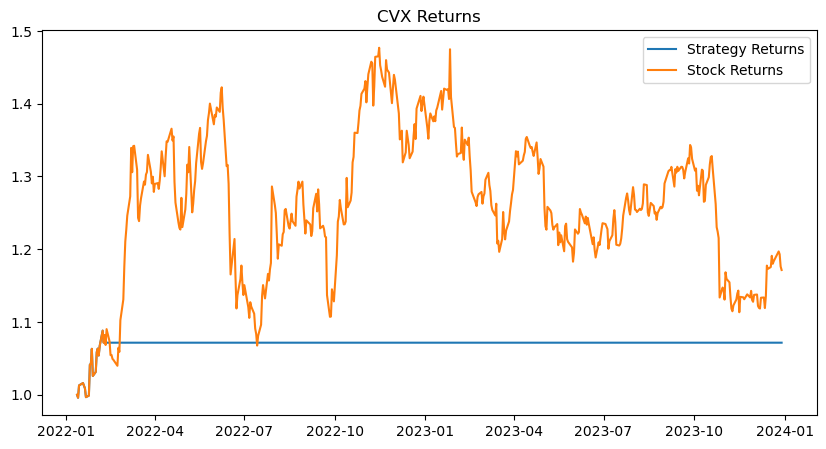

COP Accuracy: 0.5323886639676113


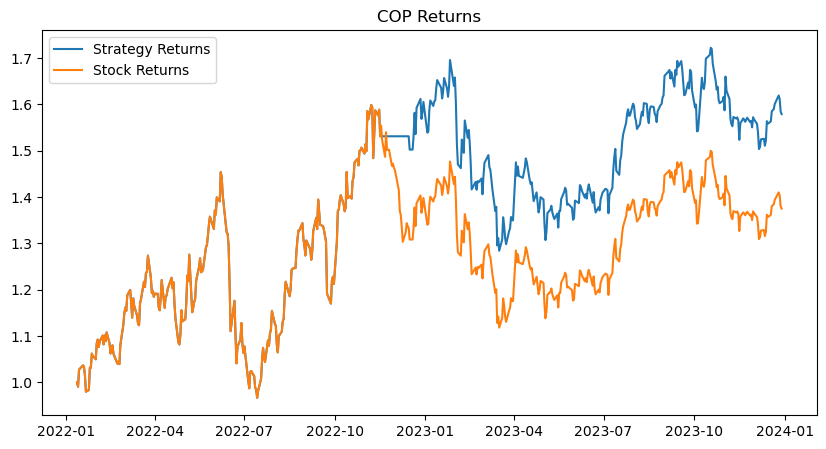

NEE Accuracy: 0.48380566801619435


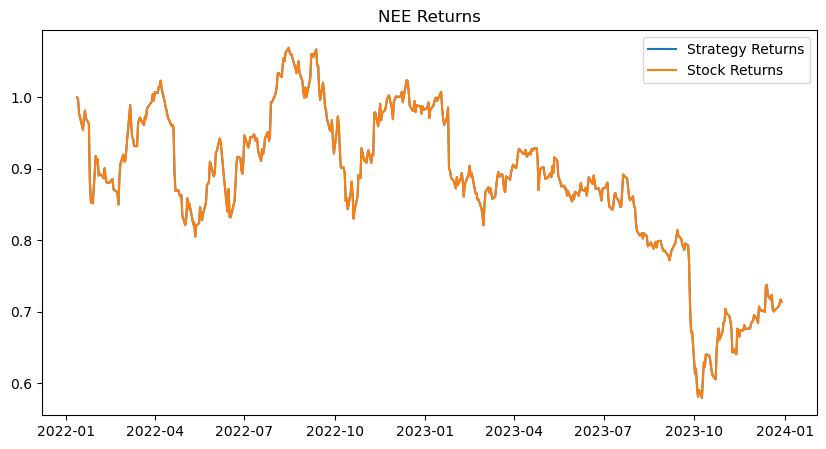

SO Accuracy: 0.4939271255060729


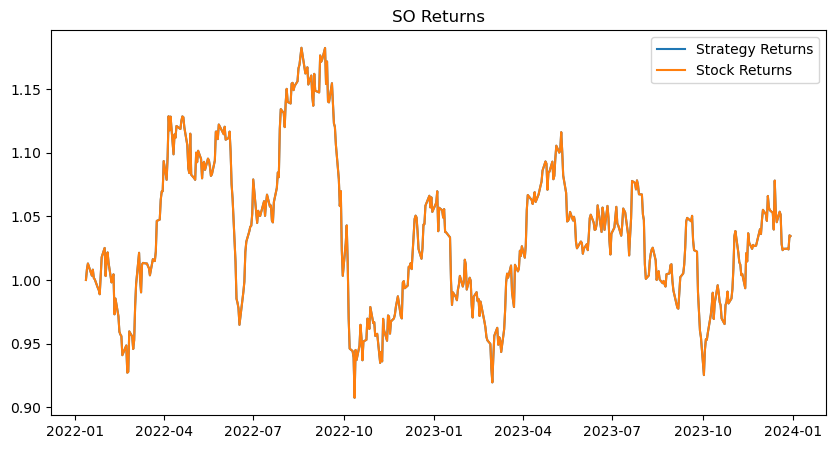

EOG Accuracy: 0.5425101214574899


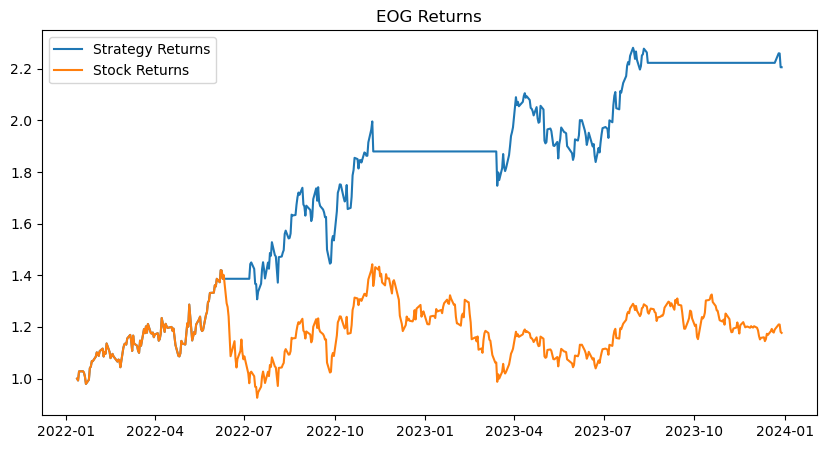

DUK Accuracy: 0.5182186234817814


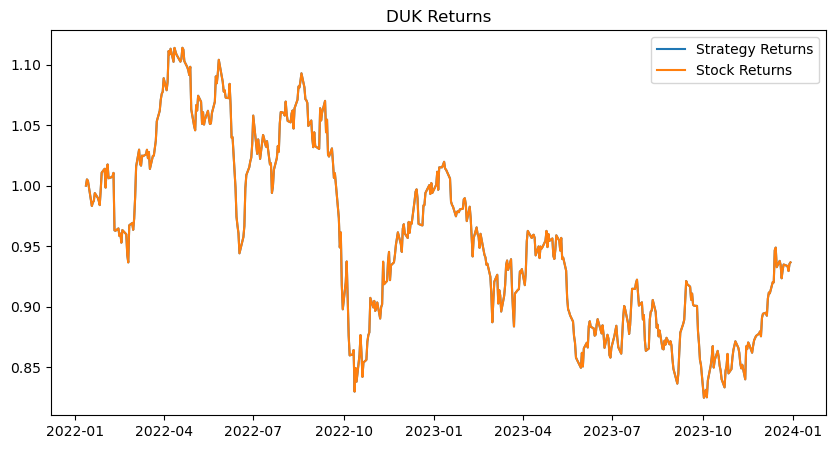

MPC Accuracy: 0.5303643724696356


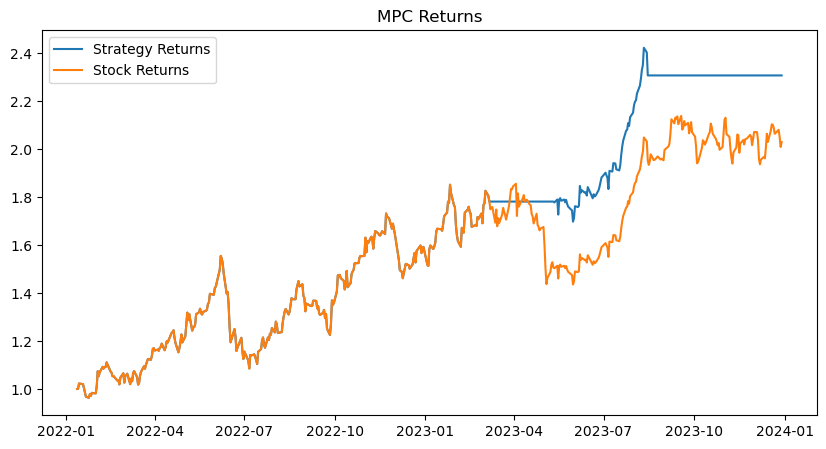

SLB Accuracy: 0.520242914979757


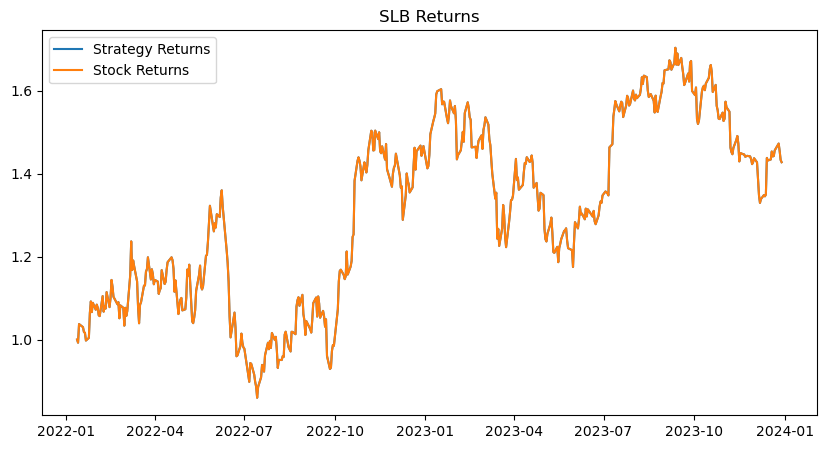

PSX Accuracy: 0.5161943319838057


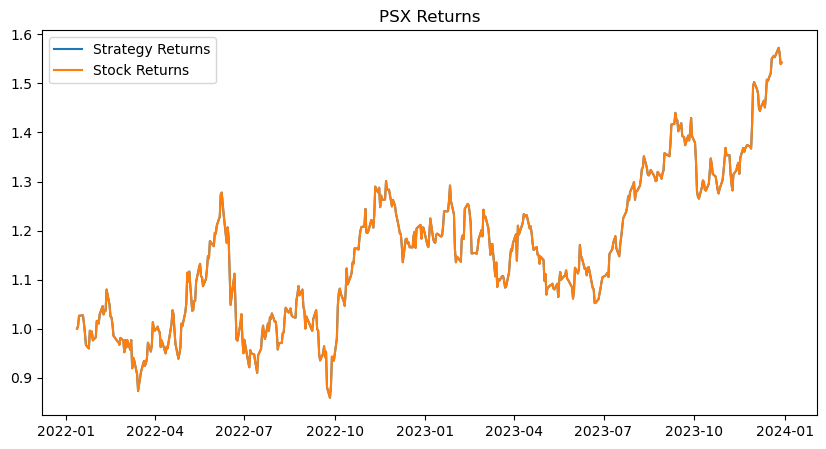

In [123]:
from sklearn.svm import LinearSVC

#model = RandomForestClassifier(n_estimators=100, random_state=42)
model = SVC()
#model = LogisticRegression()
features = ['SMA_20', 'SMA_50', 'Std_Dev', 'Z_Score', 'RSI', 'Returns']
model = model.fit(X_train[features], y_train)

market_data = yf.download('SPY', start=start, end=end)
X_test_vec = []

for i in range(10):
    market = market_data[market_data.index >= X_test[i].index[0]].copy()
    X_test_vec.append(evaluate(model, X_test[i], y_test[i], features, market_data=market))

In [43]:
X_test_vec[0]['Predicted_Signal'].mean()

0.5040485829959515

## Feature Selection

### RFE

In [141]:
from sklearn.feature_selection import RFECV
from sklearn.svm import LinearSVC
features = ['SMA_20', 'SMA_50', 'Std_Dev', 'Z_Score', 'RSI']
rfe = RFECV(LinearSVC(dual='auto'), cv = 5)

In [142]:
rfe = rfe.fit(X_train[features], y_train)

In [143]:
rfe.ranking_

array([2, 3, 1, 1, 4])

[*********************100%%**********************]  1 of 1 completed

XOM Accuracy: 0.5182186234817814


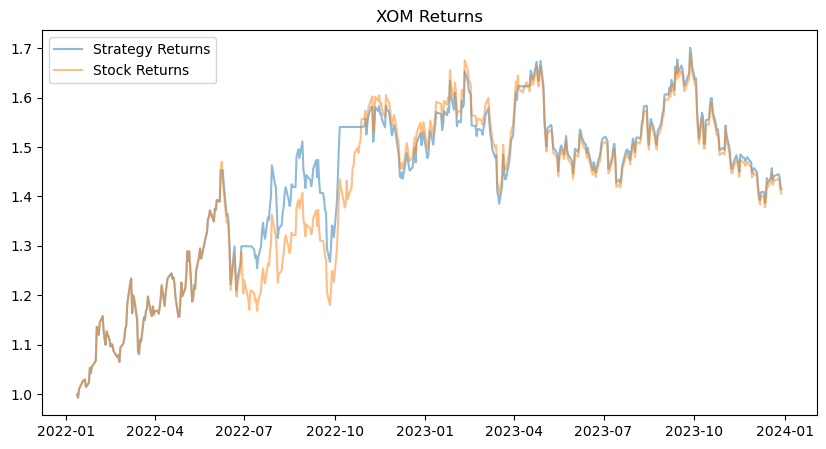

CVX Accuracy: 0.46963562753036436


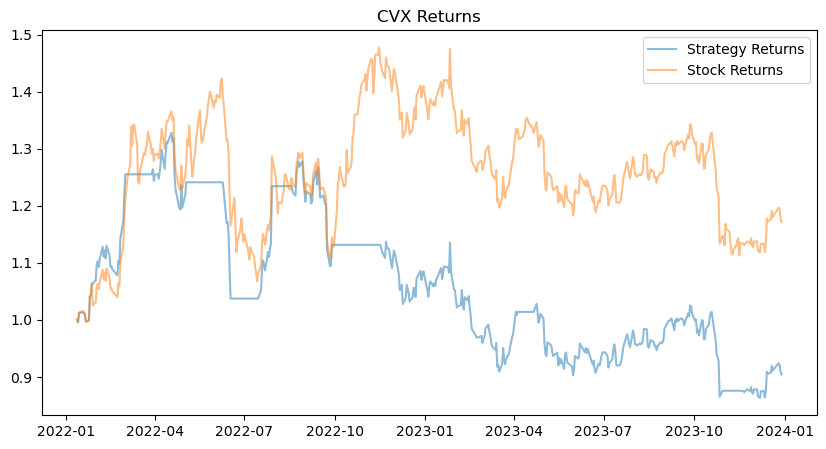

COP Accuracy: 0.5222672064777328


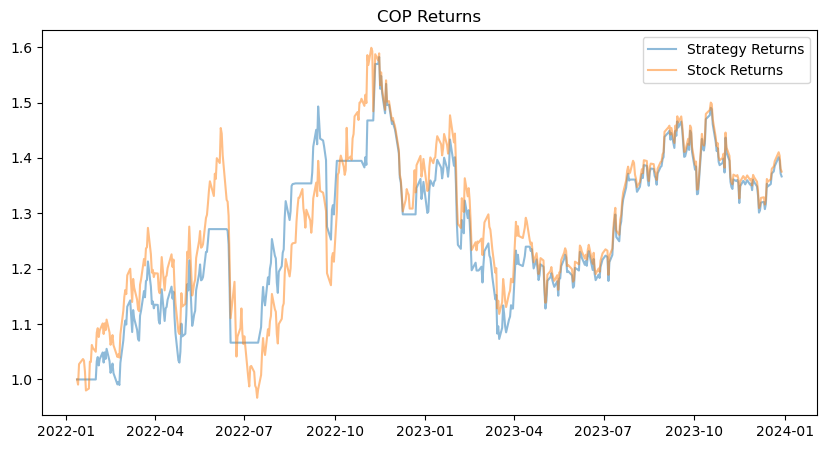

NEE Accuracy: 0.4898785425101215


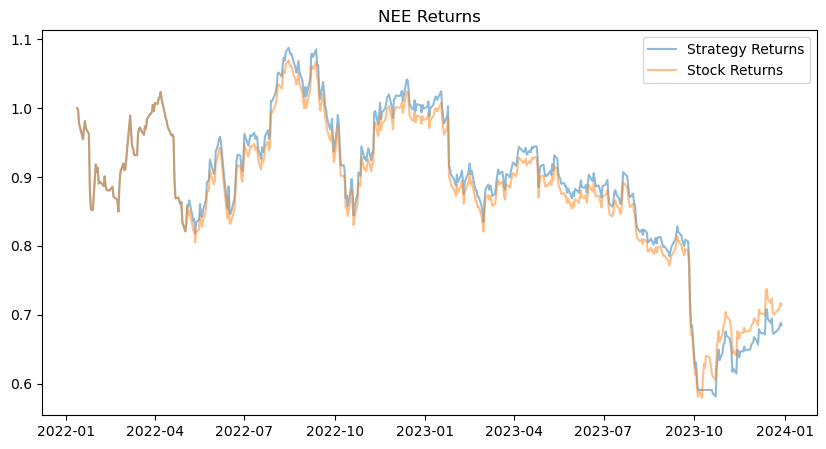

SO Accuracy: 0.4939271255060729


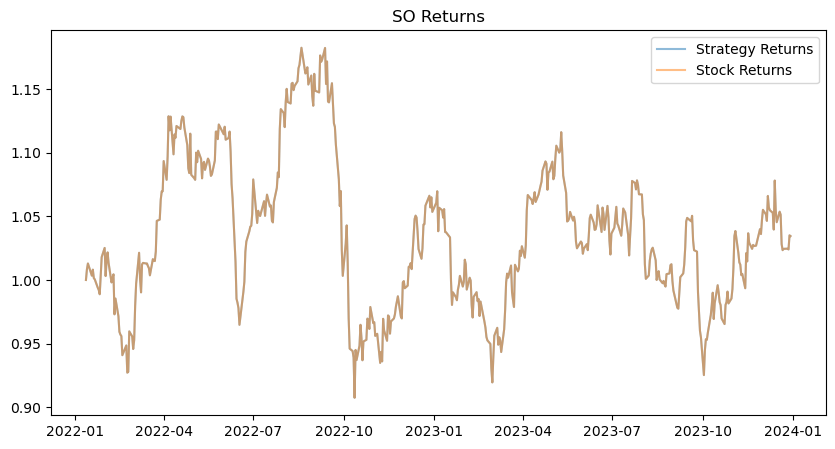

EOG Accuracy: 0.46963562753036436


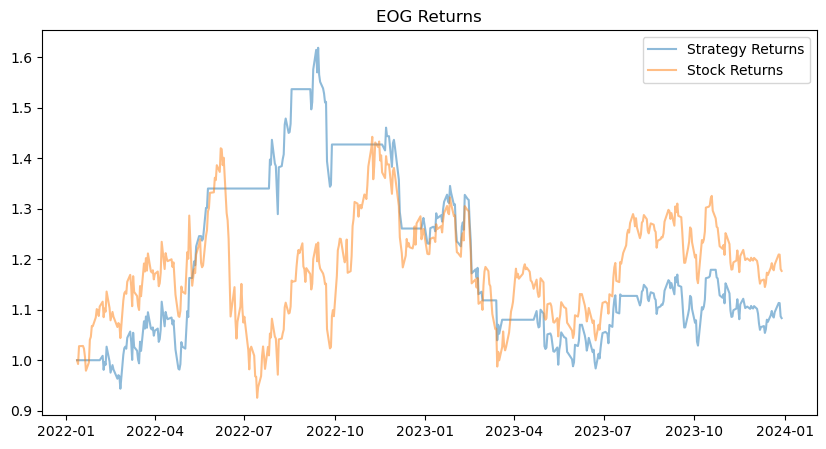

DUK Accuracy: 0.5141700404858299


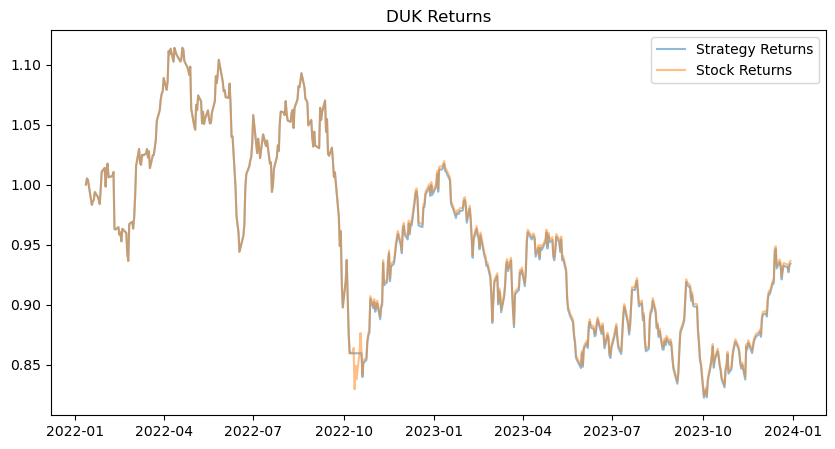

MPC Accuracy: 0.5323886639676113


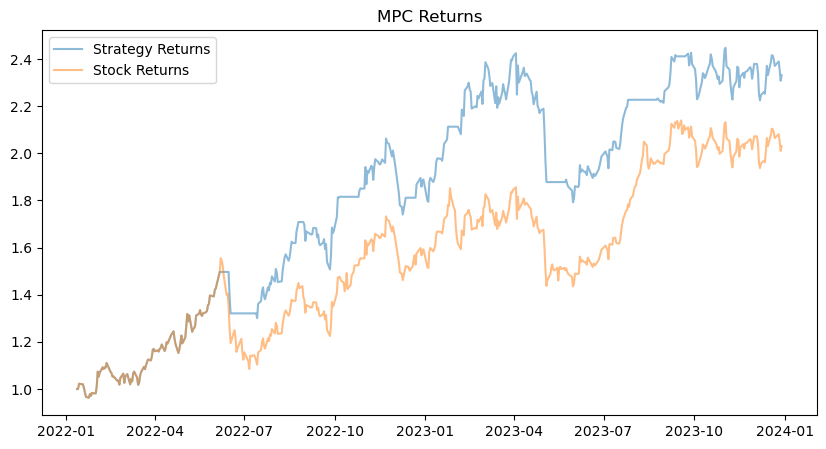

SLB Accuracy: 0.5242914979757085


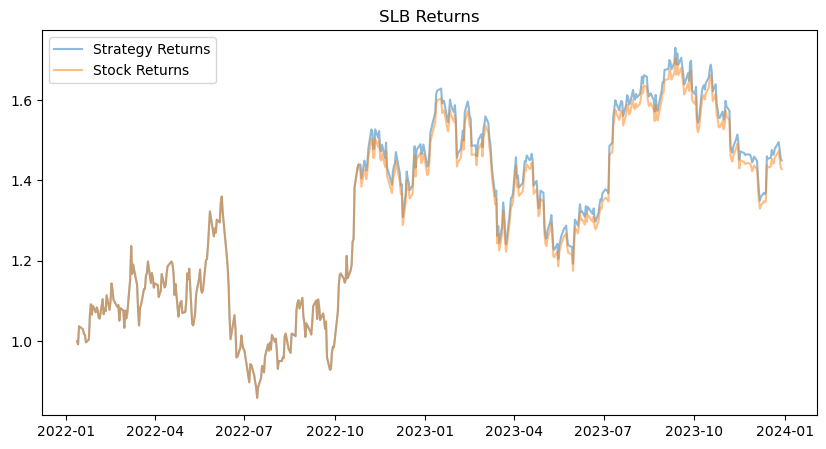

PSX Accuracy: 0.5323886639676113


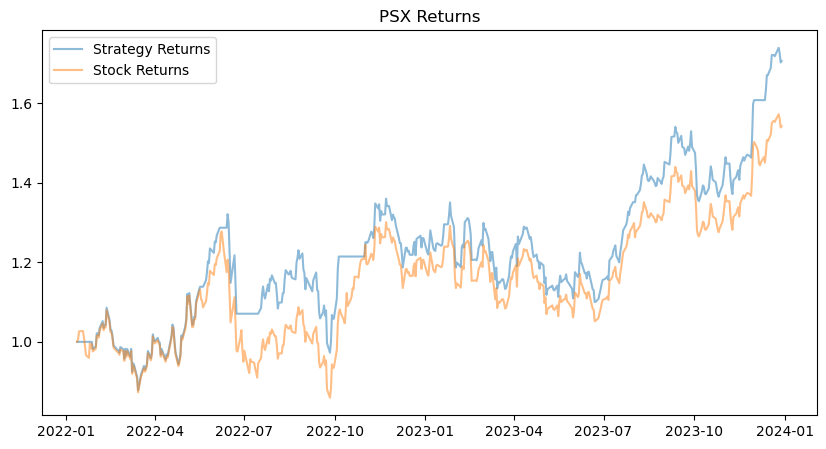

In [144]:
market_data = yf.download('SPY', start=start, end=end)
market = market_data[market_data.index >= X_test[i].index[0]].copy()
X_test_vec = []
for i in range(10):
    X_test_vec.append(evaluate(rfe, X_test[i], y_test[i], features, market_data=market))

## LSTM

In [154]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.autograd import Variable 

In [391]:
%load_ext autoreload
%autoreload 2
from lstm_model import LSTMModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [611]:
ticker = 'XOM'
start_date = '2014-01-01'
end_date = '2024-01-01'

#model = LogisticRegression()

data = yf.download(ticker, start=start_date, end=end_date)

# Calculate moving averages and std
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['Std_Dev'] = data['Close'].rolling(window=20).std()

# Calculate the z-score
data['Z_Score'] = (data['Close'] - data['SMA_20']) / data['Std_Dev']

# Calculate RSI
delta = data['Close'].diff()
up = delta.clip(lower=0)
down = -1 * delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up / ema_down

data['RSI'] = 100 - (100 / (1 + rs))

# Calculate the daily returns
data['Returns'] = data['Close'].pct_change()

# If stock price goes up or down
data['Target'] = data['Close'].shift(-1)

data.dropna(inplace=True)

# Wanted features for X and y
features = ['SMA_20', 'SMA_50', 'Std_Dev', 'Z_Score', 'RSI', 'Close', 'Returns']
X = data.loc[:, features]
y = data.iloc[:, (data.shape[1]-1):(data.shape[1])]

from sklearn.preprocessing import StandardScaler, MinMaxScaler

mm1 = MinMaxScaler()
ss1 = StandardScaler()
# mm2 = MinMaxScaler()
# ss2 = StandardScaler()

X_ss = pd.DataFrame(ss1.fit_transform(X), index=X.index, columns=X.columns)
y_mm = pd.DataFrame(mm1.fit_transform(y), index=y.index, columns=y.columns)

# Split data into first 80% and last 20%
X_train, X_test, y_train, y_test = train_test_split(X_ss, y_mm, test_size=0.2, random_state=42, shuffle=False)
# X_train_ss = pd.DataFrame(ss1.fit_transform(X_train), index=X_train.index, columns=X.columns)
# y_train_mm = pd.DataFrame(mm1.fit_transform(y_train), index=y_train.index, columns=y.columns)
# X_test_ss = pd.DataFrame(ss2.fit_transform(X_test), index=X_test.index, columns=X.columns)
# y_test_mm = pd.DataFrame(mm2.fit_transform(y_test), index=y_test.index, columns=y.columns)

[*********************100%%**********************]  1 of 1 completed


In [612]:
features_ = ['SMA_20', 'SMA_50', 'Std_Dev', 'Z_Score', 'RSI']
X_train_tensors = Variable(torch.Tensor(np.array(X_train[features_])))
X_test_tensors = Variable(torch.Tensor(np.array(X_test[features_])))

y_train_tensors = Variable(torch.Tensor(y_train.values))
y_test_tensors = Variable(torch.Tensor(y_test.values))

X_train_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

In [613]:
print("Training Shape", X_train_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([1972, 1, 5]) torch.Size([1972, 1])
Testing Shape torch.Size([494, 1, 5]) torch.Size([494, 1])


In [614]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 5 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [615]:
lstm = LSTMModel(num_classes, input_size, hidden_size, num_layers, X_train_final.shape[1]) #our lstm class 

In [616]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [617]:
for epoch in range(num_epochs):
  outputs = lstm.forward(X_train_final) #forward pass
  optimizer.zero_grad() #calculate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.16941
Epoch: 100, loss: 0.01794
Epoch: 200, loss: 0.00689
Epoch: 300, loss: 0.00291
Epoch: 400, loss: 0.00080
Epoch: 500, loss: 0.00038
Epoch: 600, loss: 0.00029
Epoch: 700, loss: 0.00026
Epoch: 800, loss: 0.00023
Epoch: 900, loss: 0.00022


In [618]:
train_predict = lstm(X_train_final)
data_predict = train_predict.data.numpy()

In [619]:
data_predict = mm1.inverse_transform(data_predict) #reverse transformation

In [620]:
X_train = pd.DataFrame(ss1.inverse_transform(X_train), index=X_train.index, columns=features)

Accuracy: 0.9523326572008114


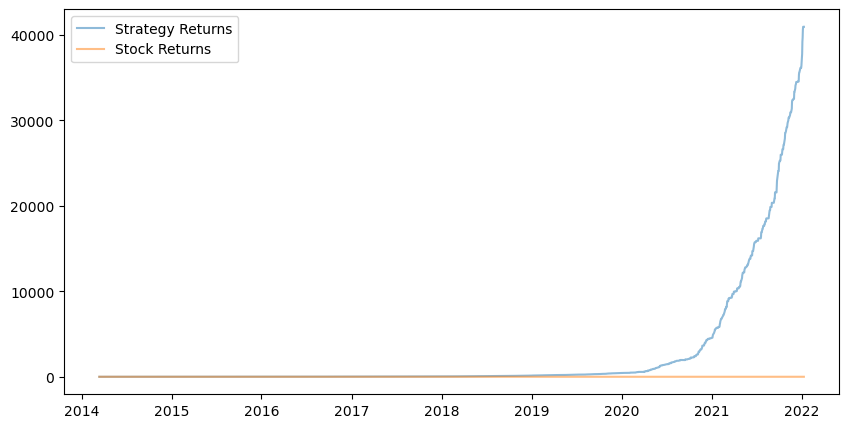

In [621]:
X_train['Predicted_Price'] = data_predict
X_train['Actual_Signal'] = (X_train['Returns'].shift(-1) > 0).astype(int)
X_train['Predicted_Returns'] = X_train['Predicted_Price'].pct_change()
X_train['Predicted_Signal'] = (X_train['Predicted_Returns'].shift(-1) > 0).astype(int)
X_train['Strategy_Returns'] = X_train['Returns'] * X_train['Predicted_Signal'].shift(1)
cumulative_strategy_returns = (X_train['Strategy_Returns'].fillna(0) + 1).cumprod()
returns = X_train.loc[X_train.index, 'Returns']
returns.iloc[0] = 0
cumulative_stock_returns = (returns + 1).cumprod()
accuracy = (X_train['Actual_Signal'] == X_train['Predicted_Signal']).mean()
print(f'Accuracy: {accuracy}')
# Calculate cumulative returns for the market
#market_data['Returns'] = market_data['Close'].pct_change()
#cumulative_market_returns = (market_data['Returns'].fillna(0) + 1).cumprod()

plt.figure(figsize=(10,5))
plt.plot(cumulative_strategy_returns, label='Strategy Returns', alpha=0.5)
#plt.plot(cumulative_market_returns, label='Market Returns')
plt.plot(cumulative_stock_returns, label='Stock Returns', alpha=0.5)
plt.legend();

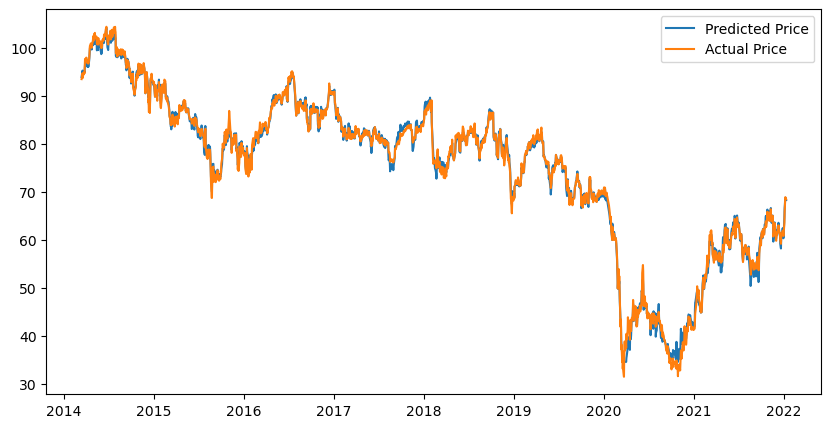

In [622]:
plt.figure(figsize=(10,5))
plt.plot(X_train['Predicted_Price'], label='Predicted Price')
plt.plot(X_train['Close'], label='Actual Price')
plt.legend();

In [623]:
test_predict = lstm(X_test_final)
data_predict = test_predict.data.numpy()

In [624]:
data_predict = mm1.inverse_transform(data_predict)
X_test = pd.DataFrame(ss1.inverse_transform(X_test), index=X_test.index, columns=features)

Accuracy: 0.9473684210526315


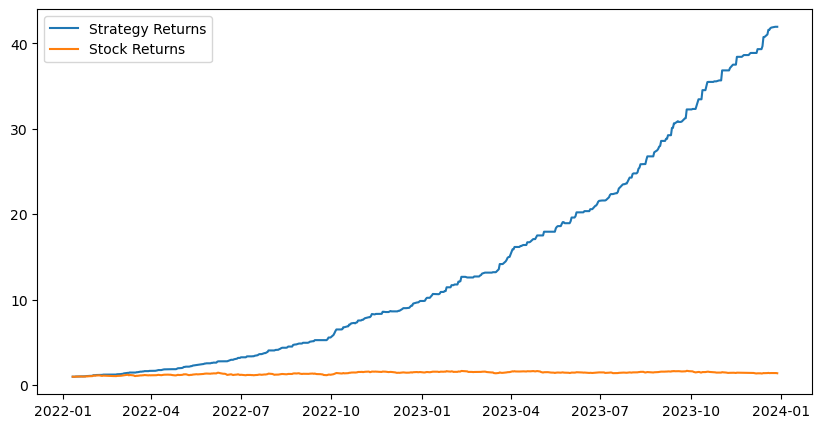

In [625]:
X_test['Actual_Signal'] = (X_test['Returns'].shift(-1) > 0).astype(int)
X_test['Predicted_Price'] = data_predict
X_test['Predicted_Returns'] = X_test['Predicted_Price'].pct_change()
X_test['Predicted_Signal'] = (X_test['Predicted_Returns'].shift(-1) > 0).astype(int)
X_test['Strategy_Returns'] = X_test['Returns'] * X_test['Predicted_Signal'].shift(1)
cumulative_strategy_returns = (X_test['Strategy_Returns'].fillna(0) + 1).cumprod()
returns = X_test.loc[X_test.index, 'Returns']
returns.iloc[0] = 0
cumulative_stock_returns = (returns + 1).cumprod()
accuracy = (X_test['Actual_Signal'] == X_test['Predicted_Signal']).mean()
print(f'Accuracy: {accuracy}')
# Calculate cumulative returns for the market
#market_data['Returns'] = market_data['Close'].pct_change()
#cumulative_market_returns = (market_data['Returns'].fillna(0) + 1).cumprod()

plt.figure(figsize=(10,5))

plt.plot(cumulative_strategy_returns, label='Strategy Returns')
#plt.plot(cumulative_market_returns, label='Market Returns')
plt.plot(cumulative_stock_returns, label='Stock Returns')
plt.legend();

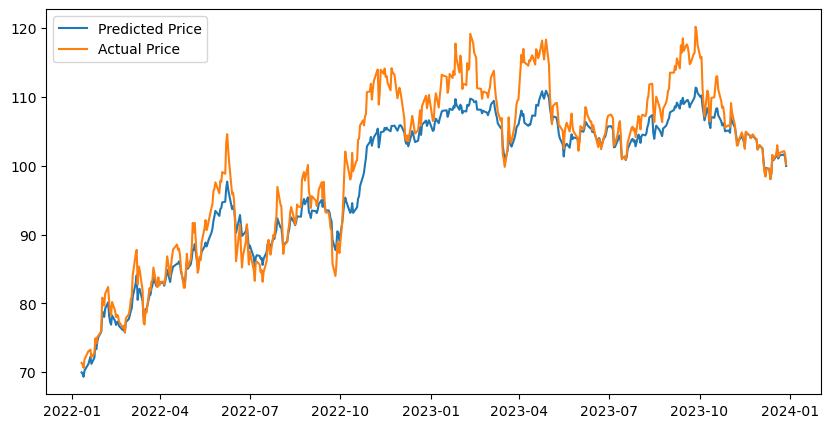

In [626]:
plt.figure(figsize=(10,5))
plt.plot(X_test['Predicted_Price'], label='Predicted Price')
plt.plot(X_test['Close'], label='Actual Price')
plt.legend();